# Title of Project: Detection of Covid 19 on Chest X-ray images
# By Aditya Raj Sahoo

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d tolgadincer/labeled-chest-xray-images

 97% 1.14G/1.17G [00:09<00:00, 131MB/s]
100% 1.17G/1.17G [00:09<00:00, 127MB/s]


In [ ]:
!unzip labeled-chest-xray-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/NORMAL-2558319-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2558319-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2559035-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2559035-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2565226-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2568157-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2597757-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2597757-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-263932-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2646645-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2646923-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2655558-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2659844-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2675017-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2675017-00

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
train_path = '/content/chest_xray/train'
test_path = '/content/chest_xray/test'
val_path = '/content/chest_xray/validation'

In [ ]:
!mkdir '/content/chest_xray/validation'
!mkdir '/content/chest_xray/validation/NORMAL'
!mkdir '/content/chest_xray/validation/PNEUMONIA'

In [ ]:
import shutil
## 624 images in total in the test file
#390 PNEUMONIA
#234 NORMAL
import os
# assign directory
directory = '/content/chest_xray/test'
for filename in os.listdir(directory):
  ct=0
  for fn in os.listdir(directory+"/"+filename):
    ct+=1
    if ((filename=="NORMAL")and (ct==117)):
      break
    elif ((filename=="PNEUMONIA") and (ct==195)):
      break
    else:
      src_path = directory+"/"+filename+"/"+fn
      dst_path = '/content/chest_xray/validation/'+filename+"/"+fn
      shutil.move(src_path, dst_path)

In [ ]:
import shutil
import os
directory = '/content/chest_xray/validation'
for filename in os.listdir(directory):
  ct=0
  for fn in os.listdir(directory+"/"+filename):
    ct+=1
  print(ct)

194
116


In [ ]:
batch_size = 16
img_height = 500
img_width = 500

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

image_gen = ImageDataGenerator(
                                   rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                              
                               )  

test_data_gen = ImageDataGenerator(rescale = 1./255)



train = image_gen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=batch_size
                                      )

test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',shuffle=False,
      class_mode='binary',
      batch_size=batch_size
      )
valid = test_data_gen.flow_from_directory(
      val_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary', 
      batch_size=batch_size
      )

Found 5232 images belonging to 2 classes.
Found 314 images belonging to 2 classes.
Found 310 images belonging to 2 classes.


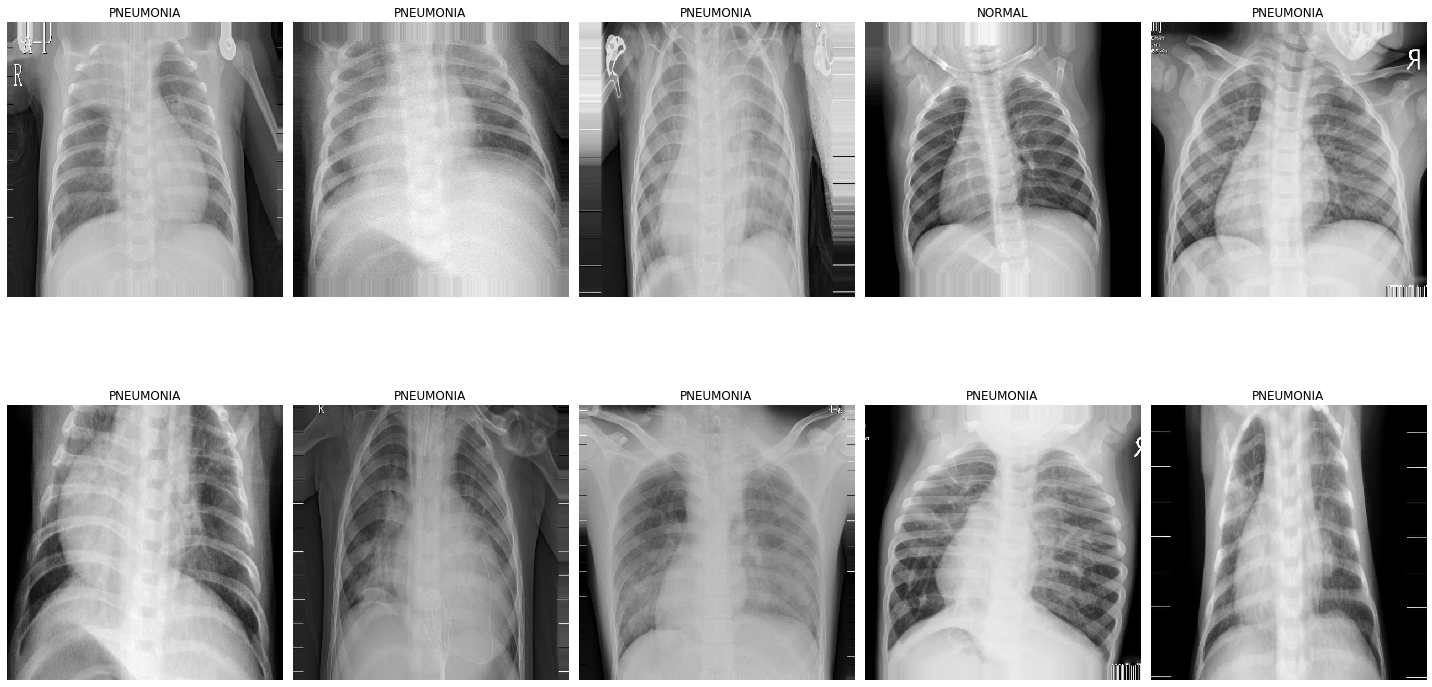

In [ ]:
plt.figure(figsize=(20, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]        
        dic = {0:'NORMAL', 1:'PNEUMONIA'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential,load_model,save_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint

In [ ]:
# let's build the CNN model

cnn = Sequential()

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Flatten())

cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))


cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 498, 498, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 249, 249, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 247, 247, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 123, 123, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 121, 121, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 60, 60, 32)       0

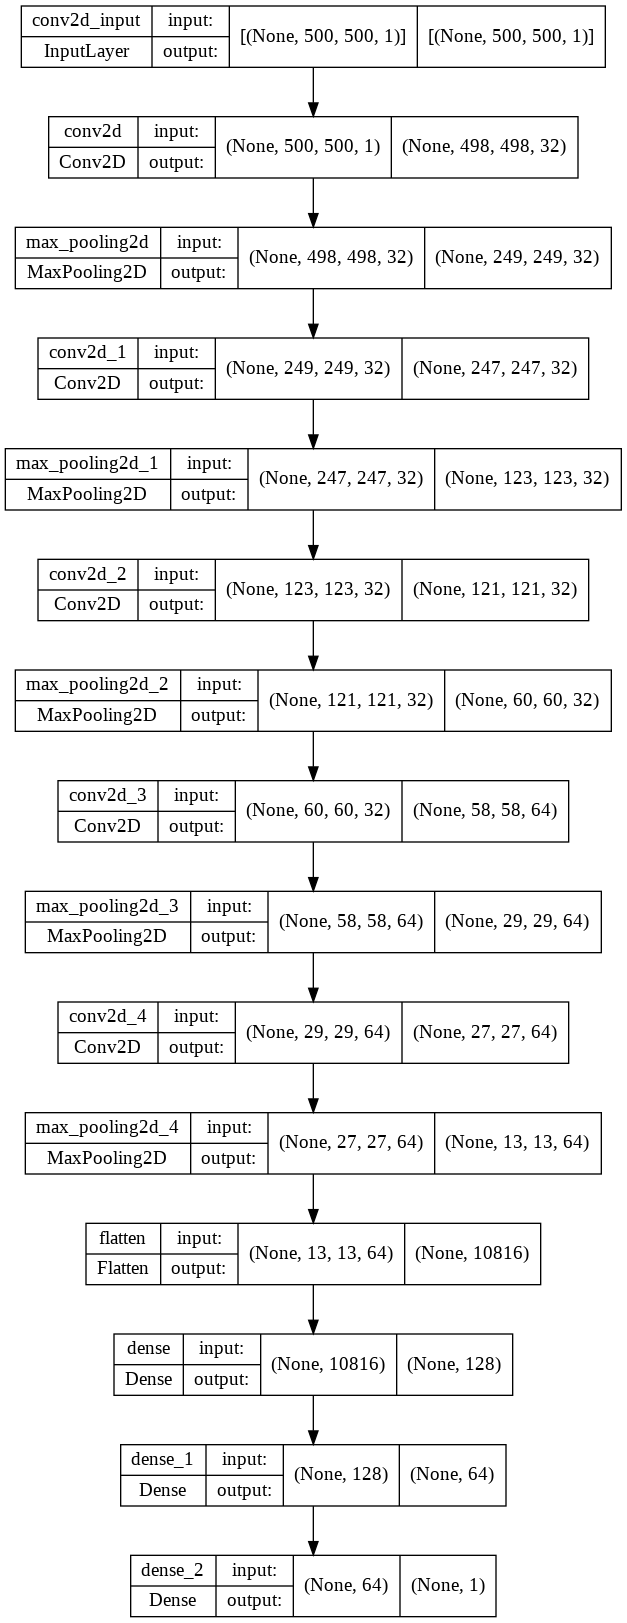

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(cnn,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [ ]:
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1)
callbacks_list = [ early, learning_rate_reduction,mc]

In [ ]:
#np.unique(train.classes)
train.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [ ]:
"""from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', np.unique(train.classes), train.classes)
cw = dict(zip( np.unique(train.classes), weights))
print(cw)"""
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train.classes),
                                        y = train.classes                                                    
                                    )
class_weights = dict(zip(np.unique(train.classes), class_weights))
class_weights

{0: 1.939214232765011, 1: 0.6737058975019315}

In [ ]:
model=cnn.fit(train,epochs=10,validation_data=valid,class_weight=class_weights, callbacks=callbacks_list)

Epoch 1/10
327/327 [==============================] - ETA: 0s - loss: 0.4130 - accuracy: 0.7682
Epoch 1: saving model to best_model.h5
327/327 [==============================] - 143s 397ms/step - loss: 0.4130 - accuracy: 0.7682 - val_loss: 0.2777 - val_accuracy: 0.8839 - lr: 0.0010
Epoch 2/10
327/327 [==============================] - ETA: 0s - loss: 0.2195 - accuracy: 0.9157
Epoch 2: saving model to best_model.h5
327/327 [==============================] - 129s 396ms/step - loss: 0.2195 - accuracy: 0.9157 - val_loss: 0.1823 - val_accuracy: 0.9452 - lr: 0.0010
Epoch 3/10
327/327 [==============================] - ETA: 0s - loss: 0.2105 - accuracy: 0.9146
Epoch 3: saving model to best_model.h5
327/327 [==============================] - 130s 397ms/step - loss: 0.2105 - accuracy: 0.9146 - val_loss: 0.1726 - val_accuracy: 0.9323 - lr: 0.0010
Epoch 4/10
327/327 [==============================] - ETA: 0s - loss: 0.1708 - accuracy: 0.9302
Epoch 4: saving model to best_model.h5
327/327 [=======

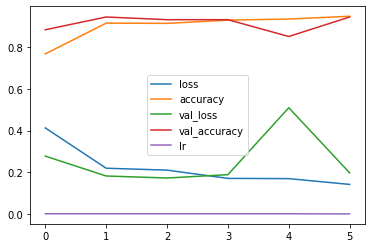

In [ ]:
pd.DataFrame(cnn.history.history).plot()

In [ ]:
test_accu = cnn.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

20/20 [==============================] - 3s 165ms/step - loss: 0.2610 - accuracy: 0.9204
The testing accuracy is : 92.03821420669556 %


In [ ]:
preds = cnn.predict(test,verbose=1)

20/20 [==============================] - 3s 145ms/step


In [ ]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

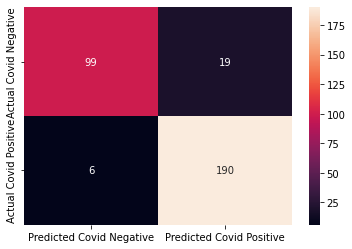

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),
                  index=["Actual Covid Negative", "Actual Covid Positive"],
                  columns=["Predicted Covid Negative", "Predicted Covid Positive"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [ ]:
 print(classification_report(y_true=test.classes, y_pred=predictions,
                            target_names =['Covid Negative','Covid Positive']
 ))

                precision    recall  f1-score   support

Covid Negative       0.94      0.84      0.89       118
Covid Positive       0.91      0.97      0.94       196

      accuracy                           0.92       314
     macro avg       0.93      0.90      0.91       314
  weighted avg       0.92      0.92      0.92       314



In [ ]:
test.reset()
x=np.concatenate([test.next()[0] for i in range(test.__len__())])
y=np.concatenate([test.next()[1] for i in range(test.__len__())])
print(x.shape)
print(y.shape)

(314, 500, 500, 1)
(314,)


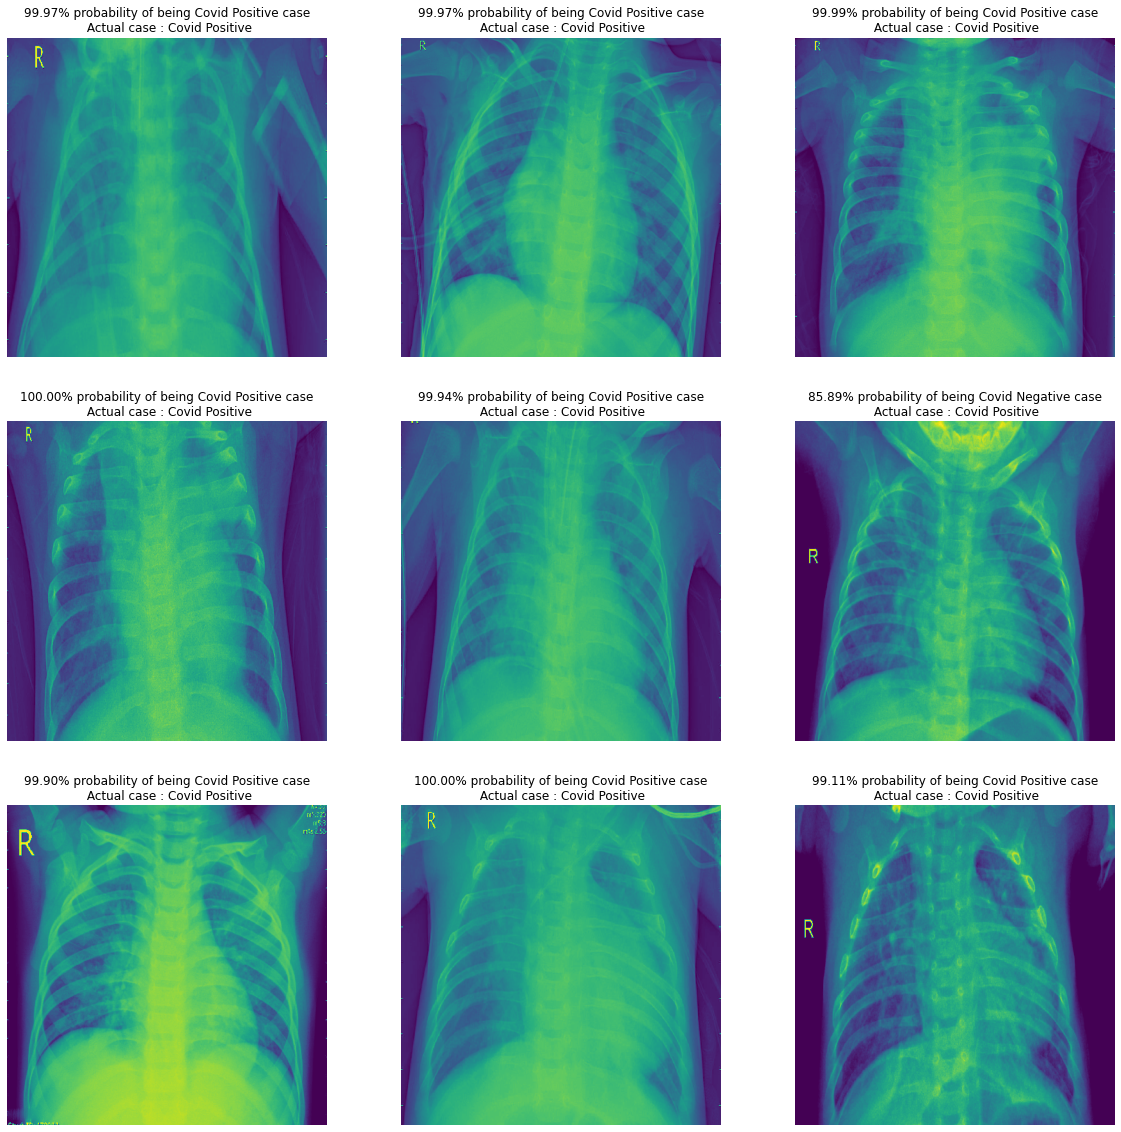

In [ ]:
dic = {0:'Covid Negative', 1:'Covid Positive'}
plt.figure(figsize=(20,20))
for i in range(0+228, 9+228):
  plt.subplot(3, 3, (i-228)+1)
  if preds[i, 0] >= 0.5: 
      out = ('{:.2%} probability of being Covid Positive case'.format(preds[i][0]))
      
      
  else: 
      out = ('{:.2%} probability of being Covid Negative case'.format(1-preds[i][0]))
      
      

  plt.title(out+"\n Actual case : "+ dic.get(y[i]))    
  plt.imshow(np.squeeze(x[i]))
  plt.axis('off')
plt.show()